# Предсказание пола человека по фотографии

## 1. Цель вычислительного эксперимента

Целью данной работы является решение задачи классификации изображений, а именно предсказание пола человека по фотографии. В качестве целевого датасета будет взят известный датасет celebA, не раз появлявшийся в kernels на Kaggle.

## 2. Описание выборок

CelebFaces Attributes Dataset (CelebA) представляет собой внушительных размеров датасет с размеченными признаками для каждого из более чем 200 тысяч лиц знаменитостей. Изображения в этом датасете включают себя множество вариаций поз и фона, что непременно положительно скажется на обобщающей способности итоговой модели. Основные особенности данного датасета:
* 10,177 личностей
* 202,599 изображений лиц
* 5 ориентиров (глаза, нос etc.) и 40 атрибутов (пол, makeup, цвет волос etc.) для каждого изображения 

## 3. Блок загрузки и предобработки выборок

Для решения нашей задачи нам понабятся только сами изображения и один из соответствующих атрибутов: пол, который представлен колонкой "Male".
Важно отметить, что датасет содержит картинки размера 218x178, что порождает 38804 признаков при разворачивании их в вектор. Это означает следующее:
1. Метрические методы классификации (KNN) не будут работать из-за крайне высокой размерности + на построение KDTree внутри KNN может уйти колоссальное количество времени.
2. Матрица размера 202,599x38,804 будет занимать > 10 гб в памяти, что делает копирующие операции с ней (например train_test_split) крайне затратными как в смысле времени, так и памяти.

Поэтому в данной задаче необходим feature extraction: для каждой картинки нужно извлечь вектор информативных признаков. Для этого воспользуемся нейросетью InceptionV3. Возьмем ее предпоследний слой размерности 2048. Стоит отметить, что выборка будет иметь не только большой размер, но и, что более важно, все еще свыше 2,000 признаков, что делает фактически невозможным запуск KNN, поэтому в пайплайн предобработки для KNN было решено добавить PCA. Также не помешает центрировать данные с помощью StandartScaler. Разумеется, это нужно сделать перед PCA, чтобы еще и убрать bias.

In [1]:
!export CUDA_VISIBLE_DEVICES=1
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import time
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pathlib import Path
from os import listdir
from skimage import io
from random import sample
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import keras, keras.layers as L
import keras.applications as zoo
from keras import Model

IMG_DIR = Path('data/img_align_celeba/')

from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


Соберем нашу модель: InceptionV3 без головы.

In [3]:
model = zoo.InceptionV3(include_top=True, weights='imagenet')

In [4]:
layer_model = Model(inputs=model.layers[0].input,
                    outputs=[model.get_layer('avg_pool').output])

Сначала загрузим изображения в черно-белой цветовой гамме, затем предскажем для них значения на предпоследнем слое и возьмем их как вектор признаков.

In [5]:
img_files = sorted([img_file for img_file in IMG_DIR.iterdir() if not img_file.name.startswith('._')])

In [ ]:
img_features = []

for img_file in tqdm_notebook(img_files):
    img_preprocessed = zoo.inception_v3.preprocess_input(plt.imread(img_file)[None] * 255)
    preds = layer_model.predict(img_preprocessed)
    img_features.append(preds)

In [16]:
img_features_np = np.vstack(img_features)

In [18]:
np.save('data/flatten_images_matrix.npy', img_features_np, allow_pickle=False)

In [3]:
X = np.load('data/flatten_images_matrix.npy')

In [4]:
X = StandardScaler().fit_transform(X)

Загрузим таргет для наших изображений.

In [5]:
attrs = pd.read_csv('data/list_attr_celeba.csv')

In [6]:
y = attrs['Male'].values
y[y == -1] = 0

И применим PCA, проведя при этом небольшой анализ зависимости качества классификации KNN от n_components.

In [11]:
from sklearn.decomposition import PCA

n_components_range = [5, 10, 30, 50, 100, 150, 200, 300, 500]
scores = []

for n_components in n_components_range:
    X_pca = PCA(n_components=n_components).fit_transform(X)
    clf = KNeighborsClassifier(n_jobs=10)
    clf.fit(X_pca[:10000], y[:10000])
    scores.append(roc_auc_score(y[10000:12000], clf.predict(X_pca[10000:12000])))

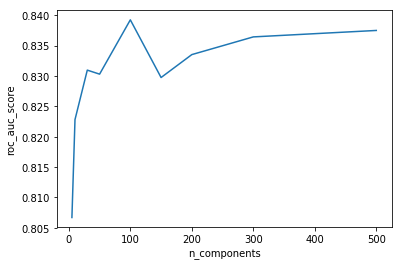

In [12]:
plt.plot(n_components_range, scores)
plt.xlabel('n_components')
plt.ylabel('roc_auc_score')
plt.show()

Возьмем наилучшее число компонент.

In [13]:
X_pca = PCA(n_components=100).fit_transform(X)

## 4. График анализа состава выборки

Поскольку наши данные по сути представляют собой выходы промежуточных слоев нейросети на соответствующих картинках, стандартные методы для анализа признаков на выбросы или корелляцию не подойдут: пространство имеет достаточно высокую размерность, да и не очень понятно, что в этих терминах есть выброс. К тому же после PCA корелляция между признаками гарантированно будет нулевая. Зато на баланс классов посмотреть явно не помешает.

Text(0,0.5,'Number of samples, %')

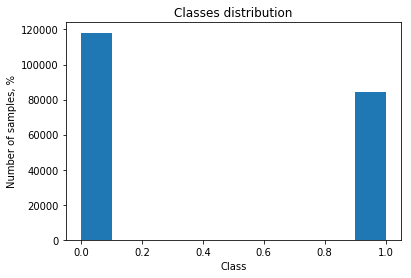

In [14]:
plt.hist(y)
plt.title('Classes distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples, %')

In [15]:
y[y == 0].shape[0] / y.shape[0]

0.5832457218446291

Явного дисбаланса классов в выборке не наблюдается: нулевой и первый класс составляют 58% и 42% соответственно.

## 5. Список моделей

* KNN (с варьируемым n_neighbors)
* SVM (с различным C)
* NN с одним скрытым слоем (варьируется число нейронов и число эпох)

In [16]:
models2params = {
    KNeighborsClassifier(): {
        'n_neighbors': [2, 5, 10, 20, 50, 100, 200]
    },
    SVC(kernel='linear', random_state=42, probability=True, class_weight='balanced', cache_size=10 ** 7): {
        'C': np.logspace(-5, -2, 10)
    },
    MLPClassifier(random_state=42): {
        'hidden_layer_sizes': [(size,) for size in range(20, 400, 10)]
    }
}

## 6. Список функций ошибки, критериев качества

Основным критерием качества в данной задаче является ROC-AUC. Для его максимизации будем пользоваться функцией потерь binary crossentropy aka logloss (ее on default использует MLPClassifier).

## 7. Способ разбиения выборки на обучение-контроль

Для валидации нашей модели будем использовать кросс-валидацию на 3-х фолдах. Также отложим тестовую выборку размера 0.1 от исходной для финальной проверки качества (примерно 20,000 объектов).

In [17]:
X_train, X_test, X_pca_train, X_pca_test, y_train, y_test = train_test_split(
    X, X_pca, y, test_size=0.1, shuffle=True, random_state=42, stratify=y)

In [18]:
cv = StratifiedKFold(shuffle=True, random_state=42)

Теперь давайте проведем небольшой анализ. Мы знаем, что сложность инференса KNN сильно зависит от числа объектов, т.к. обучение KNN по сути есть lazy-learning: основная работа выполняется на этапе предсказания (вычисляются ближайшие соседи, расстояния до них etc.). В силу размеров датасета, обучение на нем целиком может сильно замедлить работу KNN, поэтому мы попробуем выяснить: как размер датасета влияет на итоговое качество и на время обучения. Качество будем мерять при помощи кросс-валидации на 3-х фолдах.

In [23]:
def sample_n_objects(X, y, n):
    assert X.shape[0] == y.shape[0]
    idxs = sample(range(X.shape[0]), n)
    return X[idxs], y[idxs]

def score_n_objects(clf, X, y, n):
    X, y = sample_n_objects(X, y, n)
    score = cross_val_score(clf, X, y, scoring=make_scorer(roc_auc_score), cv=cv)
    return np.mean(score), np.std(score)

def test_model(clf, sample_sizes, X, y):
    scores = []
    stds = []
    times = []
    for sample_size in tqdm_notebook(sample_sizes):
        start = time.time()
        mean, std = score_n_objects(clf, X, y, sample_size)
        scores.append(mean)
        stds.append(std)
        end = time.time()
        times.append(end - start)
        
    scores = np.array(scores)
    stds = np.array(stds)
    
    plt.plot(sample_sizes, scores, label='mean roc_auc_score on folds')
    plt.fill_between(sample_sizes, scores - stds, scores + stds, label='68% confidence interval', alpha=0.3)
    plt.title('roc_auc_score of {} in dependecy on size of sample'.format(clf.__class__.__name__))
    plt.xlabel('size of sample')
    plt.ylabel('score')
    plt.legend()
    plt.show()
    plt.plot(sample_sizes, times)
    plt.title('computation time {} in dependecy on size of sample'.format(clf.__class__.__name__))
    plt.xlabel('size of sample')
    plt.ylabel('time')
    plt.show()

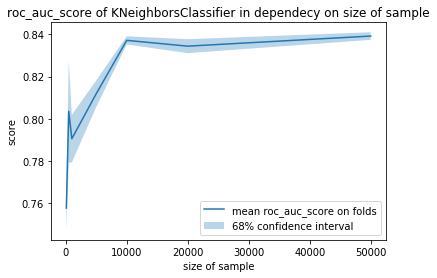

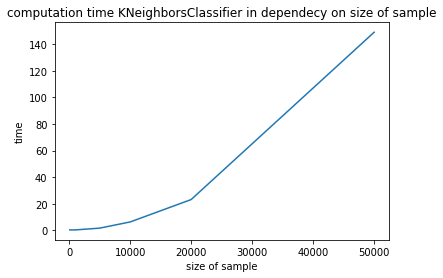

In [24]:
sample_sizes = [100, 500, 1000, 5000, 10000, 20000, 50000]

test_model(KNeighborsClassifier(n_jobs=10), sample_sizes, X_pca, y)

Прирост качества начиная с 10,000 объектов наблюдается незначительный, зато время инференса растет квадратично.

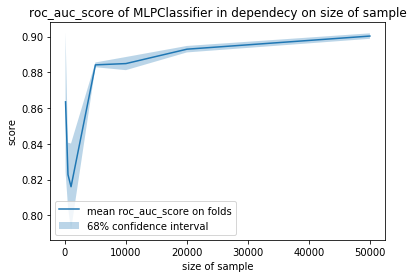

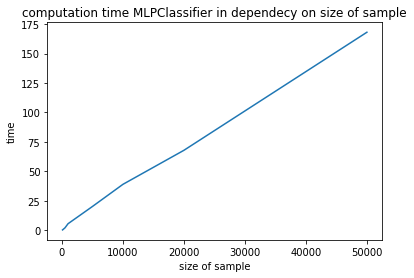

In [25]:
test_model(MLPClassifier(), sample_sizes, X, y)

Здесь время инференса растет линейно, прирост чуть более значителен.

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

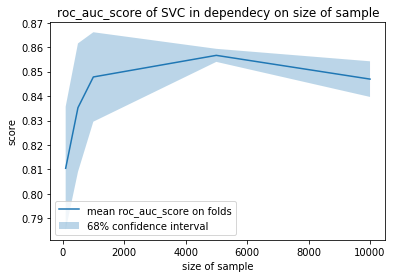

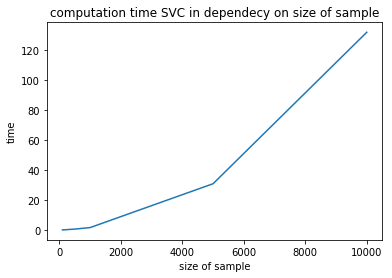

In [26]:
test_model(SVC(verbose=True, kernel='linear', cache_size=5 * 10**7), sample_sizes[:-2], X, y)

Начиная с некторого объема данных SVM имеет кубическую сложность по числу элементов в выборке (если наблюдения не умещаются в кэш), поэтому вычисление SVM на очень большом объеме данных будет весьма затруднительно и не позволит провести много экспериментов по подбору параметров. Сейчас SVM считался на сервере, что позволило выделить под кэш 50гб, но такая опция не всегда доступна.

В целом картина ясна: 10,000 объектов вполне достаточно, чтобы сравнить модели между собой, затем лучшую модель можно будет обучить на всем train подмножестве датасета.

## 8. Таблица модели/выборки/критерии качества на разбиении со стандартным отклонением

In [27]:
subsample_size = 10000

X_train_subsample, y_train_subsample = sample_n_objects(X_train, y_train, subsample_size)
X_pca_train_subsample, y_pca_train_subsample = sample_n_objects(X_pca_train, y_train, subsample_size)

Приступим к обучению моделей и подбору гиперпараметров.

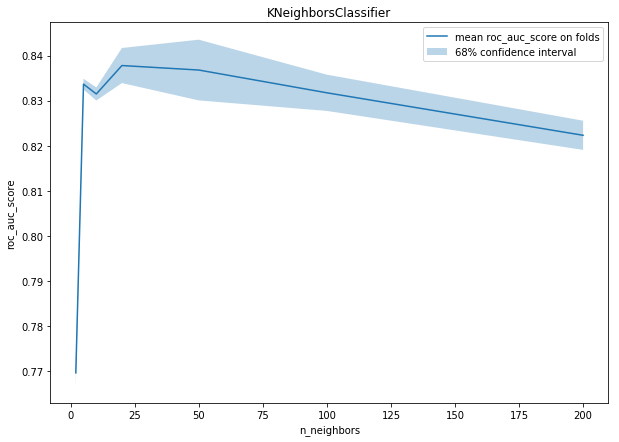

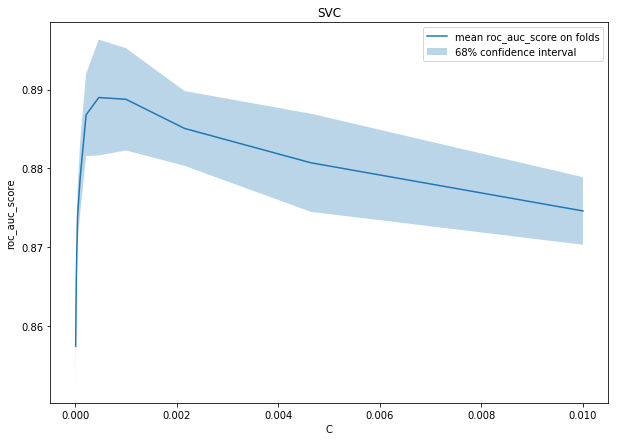

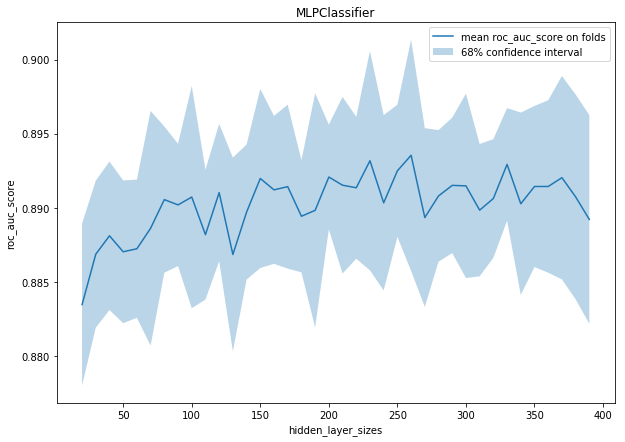

In [35]:
model2gs = {}
for model, params in tqdm_notebook(models2params.items()):
    param_name, param_values = list(params.items())[0]
    params = {key: [value] for key, value in model.get_params().items()}
    params[param_name] = param_values
    
    gs = GridSearchCV(model, params, scoring=make_scorer(roc_auc_score), cv=cv, n_jobs=-1)
    if isinstance(model, KNeighborsClassifier):
        gs.fit(X_pca_train_subsample, y_pca_train_subsample)
    else:
        gs.fit(X_train_subsample, y_train_subsample)
    if isinstance(param_values[0], tuple):
        param_values = np.array([value[0] for value in param_values])
        
    model2gs[model.__class__] = gs
    scores = gs.cv_results_['mean_test_score'] 
    stds = gs.cv_results_['std_test_score']
        
    plt.figure(figsize=(10, 7))
    plt.plot(param_values, scores, label='mean roc_auc_score on folds')
    plt.fill_between(param_values, scores - stds, scores + stds, label='68% confidence interval', alpha=0.3)
    plt.title(model.__class__.__name__)
    plt.xlabel(param_name)
    plt.ylabel('roc_auc_score')
    plt.legend()
    plt.show()

In [43]:
from collections import OrderedDict

pd.DataFrame([OrderedDict((
    ('model', model.__name__),
    ('best ROC-AUC', gs.best_score_),
    ('std on folds', gs.cv_results_['std_test_score'][np.argmax(gs.cv_results_['mean_test_score'])])
)) for model, gs in model2gs.items()])

,model,best ROC-AUC,std on folds
0,KNeighborsClassifier,0.837779,0.003890
1,SVC,0.888988,0.007362
2,MLPClassifier,0.893542,0.007798


Наилучший результат показала нейросеть, поэтому возьмем ее в качестве итоговой модели.

## 9. Анализ выбранной модели на разбиении обучение-контроль

Качество нейросети не очень сильно зависело от числа нейронов в промежуточном слое на малой части датасета, поэтому возьмем побольше нейронов из расчета того, что на большем числе данных модель сможет выучить более сложные закономерности.

Построим график зависимости функции ошибки на test-подмножестве датасета от значения структурного параметра.

In [ ]:
param_values = [50, 100, 250, 500, 750, 1000]

clfs = [MLPClassifier(hidden_layer_sizes=hidden_layer_sizes).fit(X_train, y_train)
        for hidden_layer_sizes in tqdm_notebook([(size,) for size in param_values])]

No handles with labels found to put in legend.


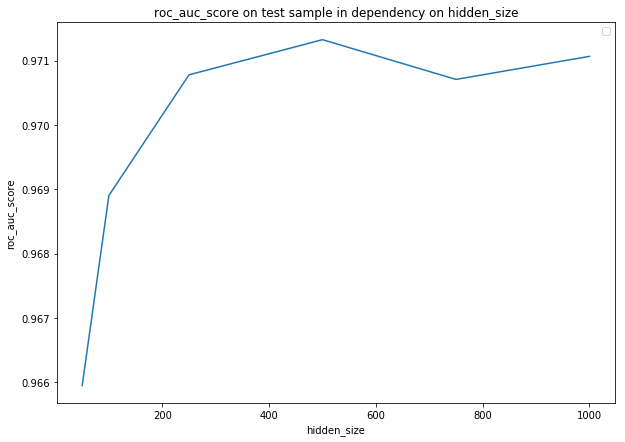

In [53]:
scores = [roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) for clf in clfs]
  
plt.figure(figsize=(10, 7))
plt.plot(param_values, scores)
plt.title('roc_auc_score on test sample in dependency on hidden_size')
plt.xlabel('hidden_size')
plt.ylabel('roc_auc_score')
plt.legend()
plt.show()

In [54]:
best_clf = clfs[4]

Построим кривую обучения.

No handles with labels found to put in legend.


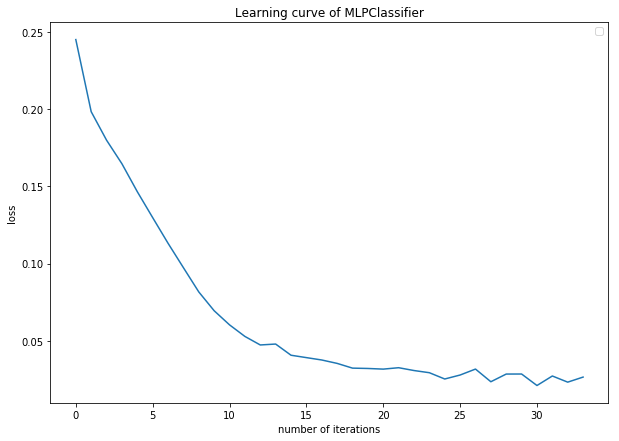

In [59]:
plt.figure(figsize=(10, 7))
plt.plot(range(best_clf.n_iter_), best_clf.loss_curve_)
plt.title('Learning curve of MLPClassifier')
plt.xlabel('number of iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

Итог: наилучшая модель дала ROC-AUC скор 97.1 на отложенной тестовой выборке.